In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RF

### The main objective of this project is to develop a forecasting algorithm to predict the medical costs billed by health insurance.

In [2]:
raw_data = pd.read_csv('insurance.csv')

In [3]:
raw_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### In the beginning, the categorical data has been encoded to be processed mathematically later. Moreover, the numerical data were standardized.

In [4]:
def clean_data(raw_data):
    data = raw_data.drop(labels = 'region', axis = 1)

    ohe = OneHotEncoder()
    enconding = ohe.fit_transform(raw_data[['region']]).toarray()
    region = pd.DataFrame(enconding, columns = ['NE', 'NW', 'SE',  'SW'])

    data = pd.concat([data, region], axis = 1)    
    
    data['sex'] = raw_data['sex'].apply(lambda x: 1 if x == "male" else 0)
    data['smoker'] = raw_data['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
    
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    data[['age', 'bmi']] = scaler_x.fit_transform(data.loc[:, ['age', 'bmi']])
    data[['charges']] = scaler_y.fit_transform(data.loc[:, ['charges']])
    data['charges GT'] = raw_data.loc[:, 'charges']

    
    return data, scaler_y


data, scaler_y = clean_data(raw_data)

### Graphical analysis

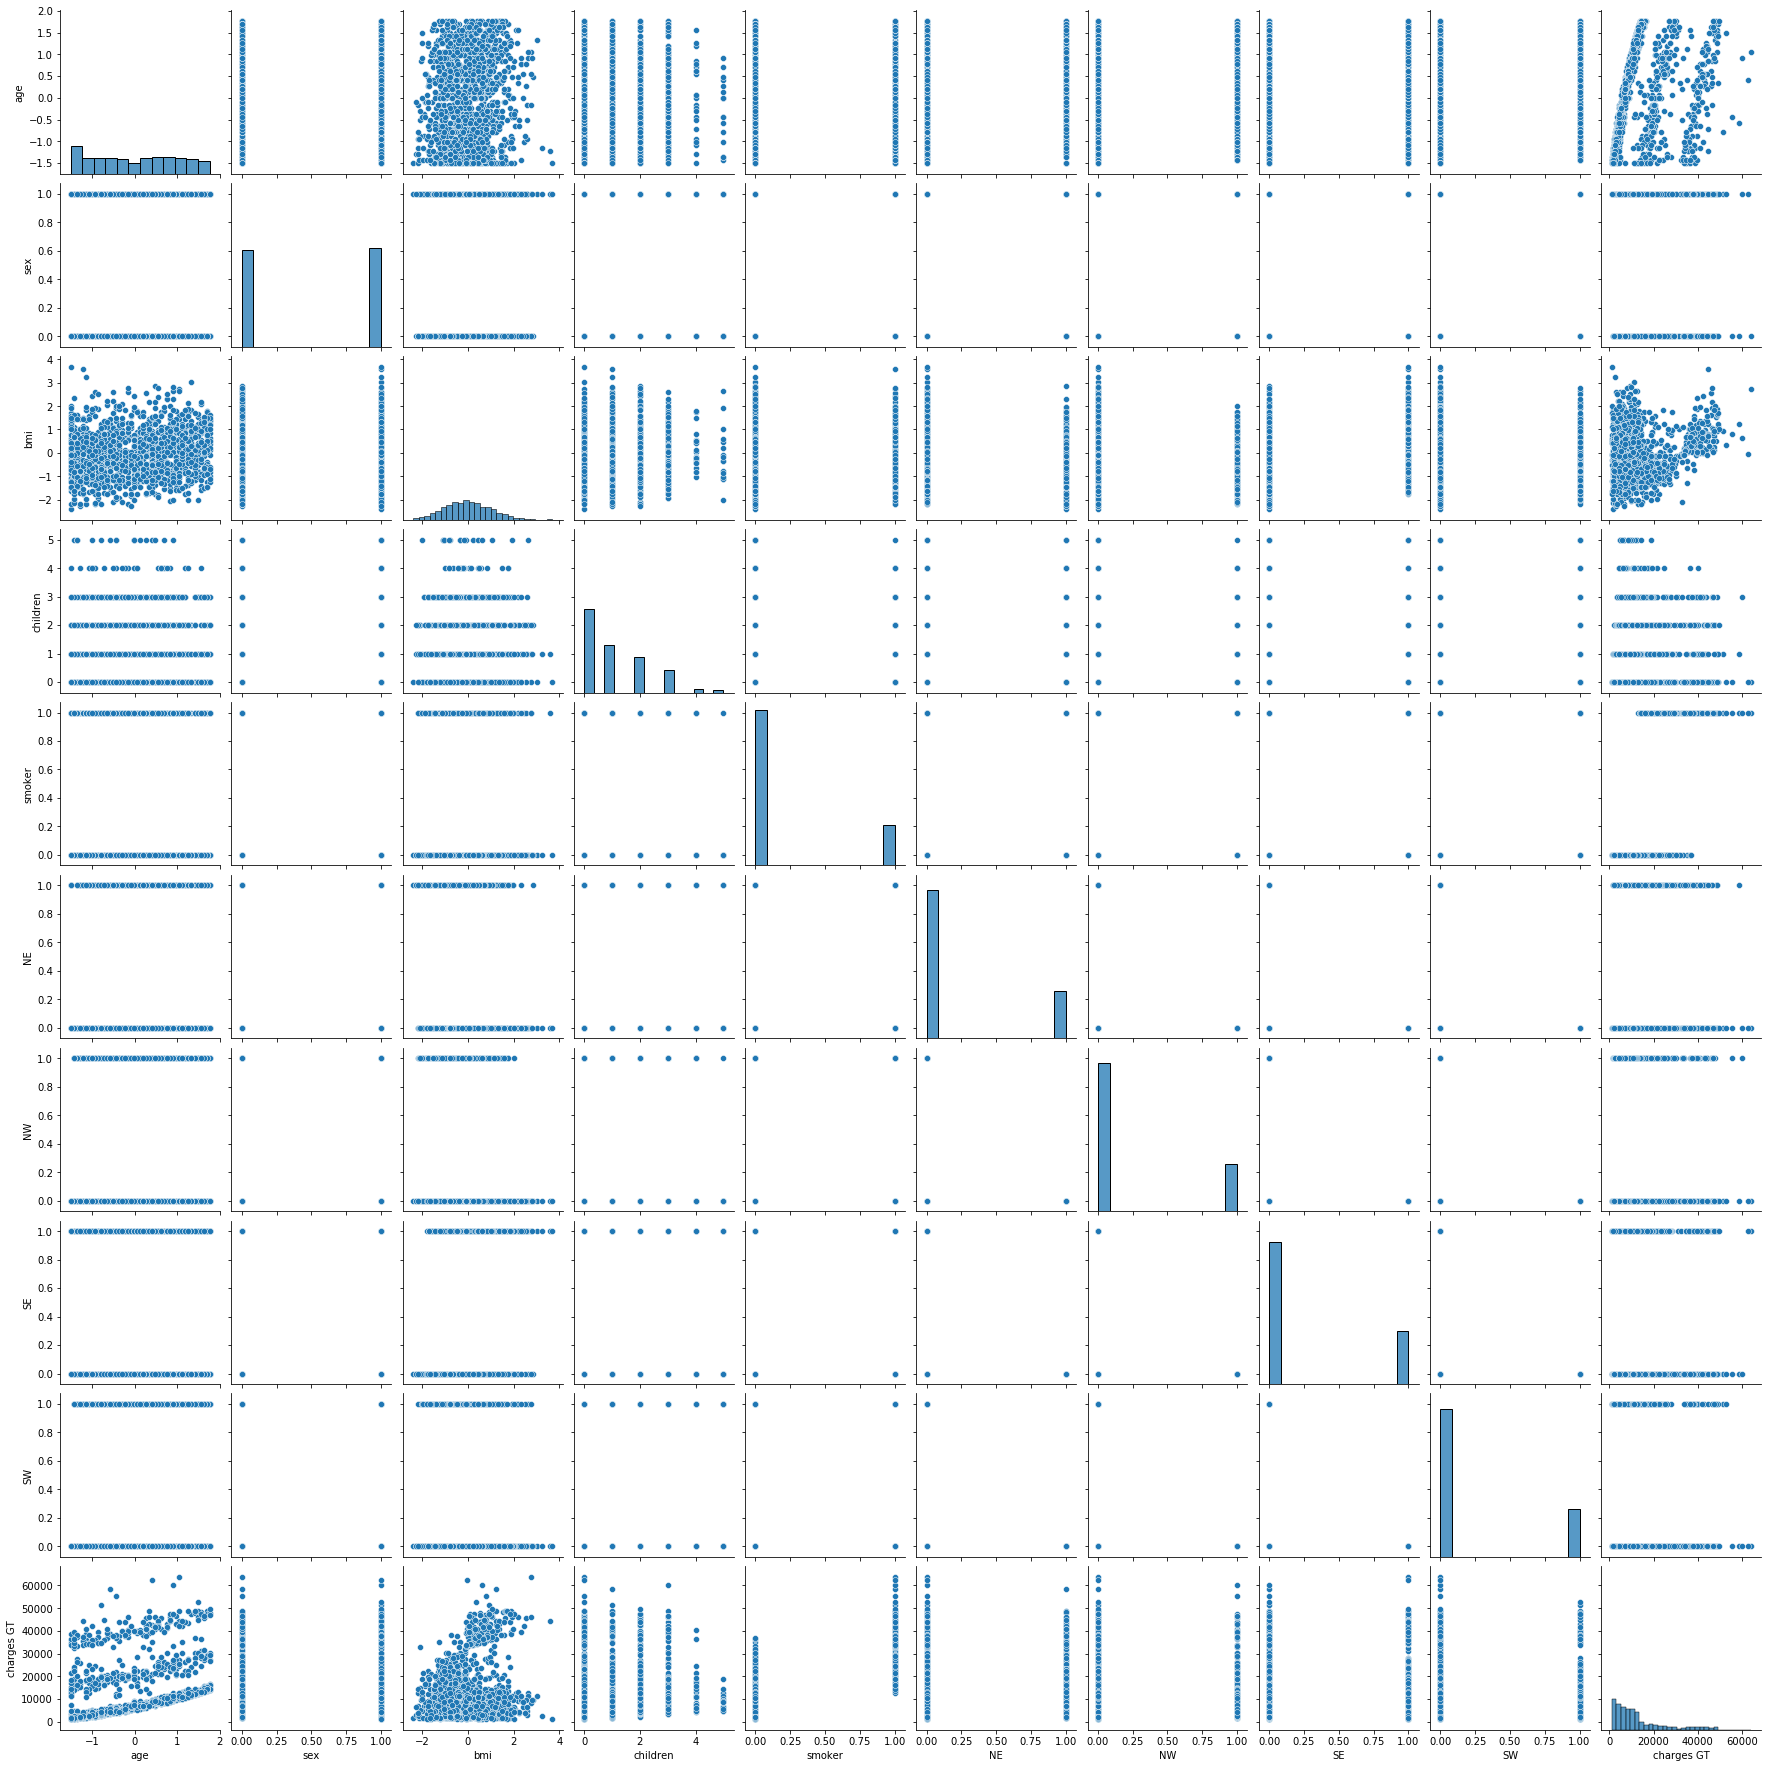

In [5]:
sns.pairplot(data.drop('charges', axis = 1))

#### As can be seen in the image above, the greater the age and the BMI, the more the charges tend to be. In addition, smokers patients are prone to have more medical costs.

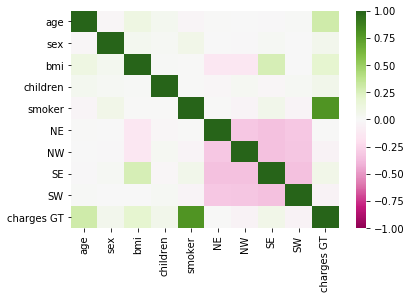

In [6]:
sns.heatmap(data.drop('charges', axis = 1).corr(), vmin = -1, vmax = 1, cmap = "PiYG")

#### As shown on the heatmap, the region where the beneficiaries lives aren't significant information. Thus, those categories have dropped out. 

In [7]:
x = data.drop(labels = ['charges', 'charges GT', 'NE', 'NW', 'SE',  'SW'], axis = 1)
y = data.loc[:, ['charges', 'charges GT']]

### Principal component analysis

In [8]:
pca = PCA()
pd.DataFrame(pca.fit_transform(x))
pca.explained_variance_ratio_

array([0.37766889, 0.28541117, 0.23042693, 0.06506219, 0.04143082])

 #### The main principal components do not represent the whole data well. Therefore, those components cannot be used.

### The buit functions for this project are described below

In [9]:
def train(x_train, y_train):
    model = SVR()
    model.fit(x_train, y_train)
    
    return model

In [10]:
def test(x_test,test_idx, y_pred, model):
    pred = model.predict(x_test)
    y_pred[test_idx] = pred
    
    return y_pred, pred

In [11]:
def processing(x, y):
    folds = 5

    kf = KFold(n_splits = folds, shuffle=True, random_state=0)
    y_pred = np.ones(len(y))
    r2 = np.array([])
    for train_idx, test_idx in kf.split(x):
        x_train = x.loc[train_idx]
        y_train = y['charges'].loc[train_idx]
        
        x_test = x.loc[test_idx]
        y_test = y['charges'].loc[test_idx]

        model = train(x_train, y_train)
        y_pred, pred = test(x_test, test_idx,y_pred, model)
        
        r2 = np.append(r2, r2_score(y_test, pred))
        
    return r2, y_pred

In [12]:
def plot_graph(y, prediction):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(y['charges GT'].iloc[:-1:25])
    ax.plot(range(0, len(prediction), 25), prediction[:-1:25])

    ax.set_title("Prediction versus Ground Truth")
    ax.legend(["Ground Truth", "Prediction"])
    ax.set_xlabel('Sample number')
    ax.set_ylabel("Charges")

In [13]:
def print_results(scaler_y):
    print("Mean R2: {:.2f}%".format(100 * r2.mean()))
    print("R2 deviation: {:.2f}\n".format(r2.std()))
    
    prediction = scaler_y.inverse_transform(y_pred)
        
    plot_graph(y, prediction)
    

### Getting results

Mean R2: 83.43%
R2 deviation: 0.04



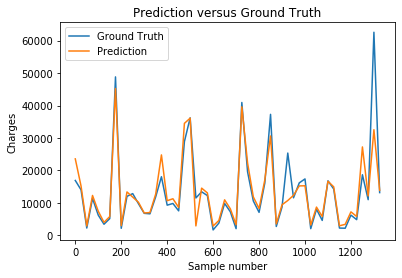

In [14]:
r2, y_pred = processing(x, y)   
print_results(scaler_y)

#### As result, it was obtained a mean determination coefficient of 83.43% with a 4% of standard deviation. The graph above shows the difference between predicted charges and actual charges.